# Example: Compare distributions for common particles in two models

In this example, we generate the pseudorapidity and Feynman-x distributions for selected particles in two models and compare them visually.

Requires extra packages: matplotlib, tqdm, boost-histogram, particle, joblib

In [1]:
import matplotlib.pyplot as plt
import boost_histogram as bh
from tqdm import tqdm
from particle import literals as lp, Particle
import joblib  # only joblib works reliably in notebooks
import numpy as np

from chromo.constants import GeV
from chromo.kinematics import CenterOfMass
import chromo.models as im

In [2]:
# We want to simulate pp interactions at 1 TeV center-of-mass

# The event kinematics objects defines the collision and its frame.
# Here we want pp collisions at 1 TeV center-of-mass energy.
ekin = CenterOfMass(
    100 * GeV,
    "proton",
    "proton"
)

# How many events to generate
n_events = 10000

In [3]:
pid_axis = bh.axis.IntCategory([
    x.pdgid for x in (lp.pi_0, lp.pi_plus, lp.pi_minus, lp.K_plus, lp.K_minus, lp.proton, lp.antiproton)
])

models = [
    im.EposLHC,
    im.Sibyll21,
    im.Sibyll23d,
    im.QGSJet01d,
    im.QGSJetII04,
    im.Pythia6,
    im.Pythia8,
]

@joblib.delayed
def run(Model):    
    # Create mode instance here.
    # This typically generates a banner for each model.
    # Models can only be created once.

    m = Model(ekin, seed=1)
    m.set_stable(lp.pi_0.pdgid)

    # Histogram for Feynman-x distributions
    hx = bh.Histogram(pid_axis, bh.axis.Regular(30, -1, 1))

    # Histogram for pseudorapidity distributions
    heta = bh.Histogram(pid_axis, bh.axis.Regular(30, -7, 7))

    for event in tqdm(m(n_events), total=n_events):
        event = event.final_state() # select only final state particles
        with np.errstate(divide="ignore", invalid="ignore"):
            hx.fill(event.pid, event.xf)
            heta.fill(event.pid, event.eta)

    return m.label, hx, heta

with joblib.Parallel(n_jobs=10, batch_size=1) as pool:
    results = pool(run(m) for m in models)

results = {label: rest for (label, *rest) in results}


 |                                                  |
 |                                                  |
 |                 S I B Y L L  2.1                 |
 |           QUARK GLUON STRING JET MODEL           |
 |                                                  |
 |                                                  |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |                        BY                        |
 |                        BY                        |
 |        N.N. KALMYKOV AND S.S. OSTAPCHENKO        |
 |                   Ralph ENGEL                    |
 |                                                  |
 |           R.S. FLETCHER, T.K. GAISSER            |
 |            e-mail: serg@eas.npi.msu.su           |
 |               P. LIPARI, T. STANEV               |
 |                                                  |
 |                                                  |
 | Publication to be cited w

/Users/anatoli/devel_mac/impy/src/chromo/models/qgsjet.py:58: RuntimeWarning: stable particles cannot be changed in QGSJet01d
  warnings.warn(
 65%|██████▌   | 6533/10000 [00:00<00:00, 16427.42it/s]

 SIG_AIR_INI: initializing target: (i,A)           2          14 nit..
 SIG_AIR_INI: initializing target: (i,A)           3          16 oxy..


 26%|██▋       | 2649/10000 [00:03<00:08, 827.20it/s] 

 done
  qgaini: nuclear cross sections readout from the file sectnu-II-04


/Users/anatoli/devel_mac/impy/src/chromo/models/qgsjet.py:58: RuntimeWarning: stable particles cannot be changed in QGSJetII04
  warnings.warn(
100%|██████████| 10000/10000 [00:11<00:00, 852.99it/s]


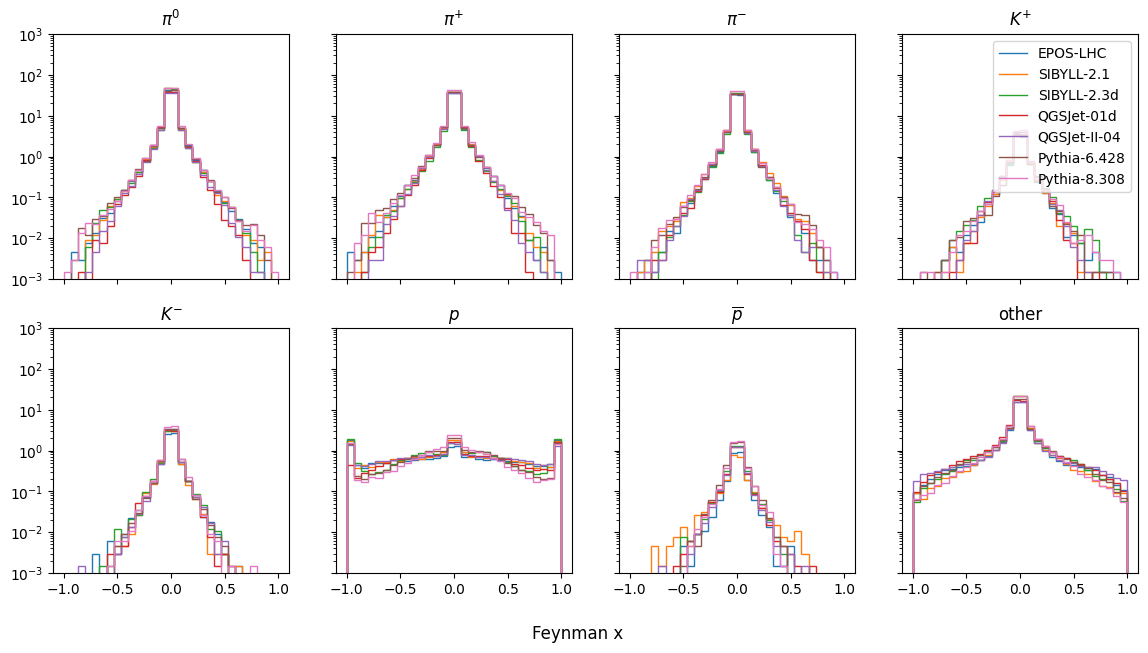

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=True, sharey=True)

# boost-histogram axes contain overflow bins to count everything else,
# we use this here to show a histogram of all other particles
labels = [f"${Particle.from_pdgid(pid).latex_name}$" for pid in pid_axis]
labels += ["other"]

for model, (hx, heta) in results.items():
    a = hx.axes[1]
    values = hx.values(True) # this returns the full histogram including overflow bins
    values = values[:, 1:-1] # strip the overflow bins from the second axis
    labels = [f"${Particle.from_pdgid(pid).latex_name}$" for pid in hx.axes[0]]
    labels += ["other"]
    for i, (label, axi) in enumerate(zip(labels, ax.flat)):
        axi.stairs(values[i] / n_events / a.widths, a.edges, label=model)
        axi.set_title(label)
plt.semilogy()
plt.ylim(1e-3, 1e3)
fig.supxlabel("Feynman x")
ax[0, -1].legend();

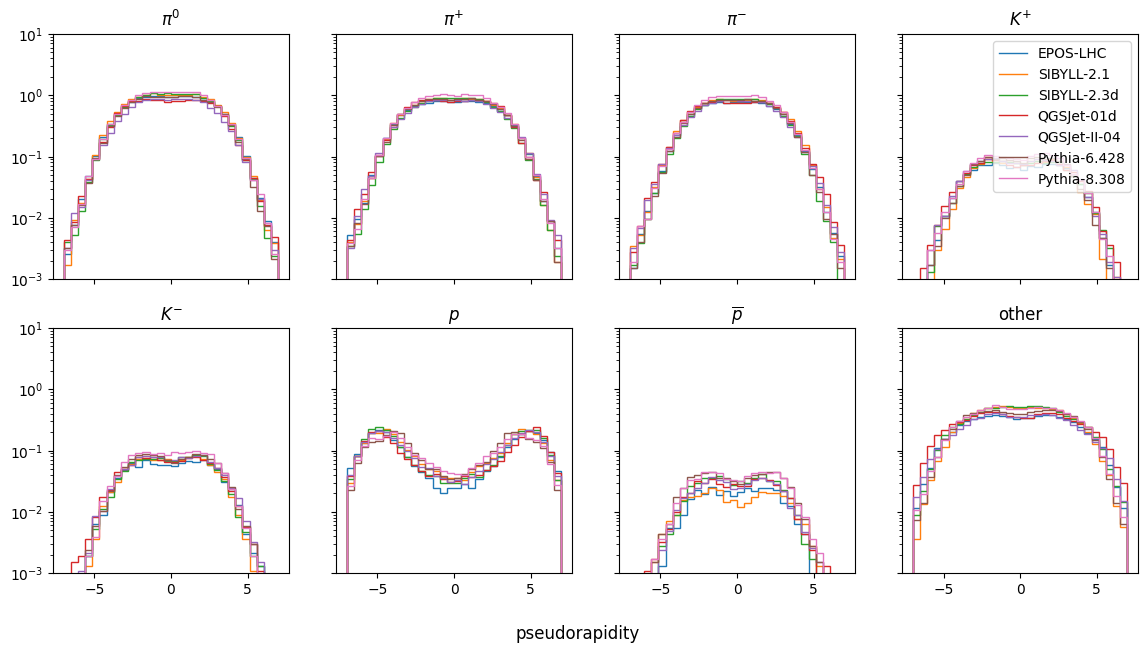

In [5]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=True, sharey=True)

for model, (hx, heta) in results.items():
    a = heta.axes[1]
    values = heta.values(True)
    values = values[:, 1:-1]
    for i, (label, axi) in enumerate(zip(labels, ax.flat)):
        axi.stairs(values[i] / n_events / a.widths, a.edges, label=model)
        axi.set_title(label)
plt.semilogy()
plt.ylim(1e-3, 1e1)
fig.supxlabel("pseudorapidity")
ax[0, -1].legend();